In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from cmcrameri import cm
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit


from src.AnalysisFunctions import *
from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack

In [3]:
# experimental parameters
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

dt = 4 # h
dt_holo = 12 # frames per hour
dt_tomo = 4  # frames per hour
blur_factor = 1.5
#holomonitor_scaling = 100

h_max = 18

fmin_holo = [188, 1, 1, 130, 1, 1]
fmax_holo = 121

fmin_tomo = 1
fmax_tomo = 40

holo_dict = json.load(open("../../data/Holomonitor/settings.txt"))
tomo_dict = json.load(open("../../data/Tomocube/settings.txt"))
tomo_dict

{'files': ['../../data/Tomocube/MDCK_10.02.2025/A2P1'],
 'fmin': [1],
 'fmax': [40],
 'blur_factor': 0.95}

In [ ]:
# IMPORT DATA
im_size = 975
density = []
spatial_corr = []
spatial_dist = []
mean_im = []
var_im = []


# holomonitor
for dataset in tqdm(range(len(holo_dict["files"]))):
    # import data
    file = holo_dict["files"][dataset].split("/")[-1]
    folder = holo_dict["files"][dataset].split(file)[0]

    h_im = import_holomonitor_stack(folder, file, f_min=holo_dict["fmin"][dataset], f_max=holo_dict["fmax"][dataset])[:, :im_size, :im_size]
    #h_im[h_im > h_max] = h_max

    df = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")
    blur_factor = holo_dict["blur_factor"]
    conversion_factor = pix_to_um

    # blur data
    hblur = np.zeros_like(h_im)
    for f in range(len(h_im)):
        r_cell = average_cell_radius(df, f, conversion_factor, blur_factor=blur_factor)
        hblur_tmp = gaussian_filter(h_im[f], r_cell)

        hblur[f] = hblur_tmp

    im = hblur
    autocorr = np.zeros_like(im[0])
    for t in range(len(im)):
        autocorr += spatial_autocorrelation(im[t]) / len(im)
    
    dist, mean, std = radial_distribution(autocorr, pix_to_um)
    spatial_corr.append(mean)
    spatial_dist.append(dist)


100%|██████████| 6/6 [01:46<00:00, 17.78s/it]


In [9]:
# bin_size = 100
# min_density = 1250
# max_density = 2850
# n_bins = int((max_density - min_density) / bin_size)

# #binned_density = np.zeros(n_bins)
# density = np.array(density)
# autocorr = np.array(spatial_autocorr)
# Cr_density = []
# #correlation_lenght = correlation_lenght[:, :len(density[0])]

# for i in range(n_bins):
#     mask = (density >= min_density + i*bin_size) * (density < min_density + (i+1)*bin_size)
#     #binned_density[i] = density.min() + (i+0.5)*bin_size

#     Cr_density.append(np.mean(autocorr[mask], axis=0))


Correlation lenght: 25.57 +/- 0.06


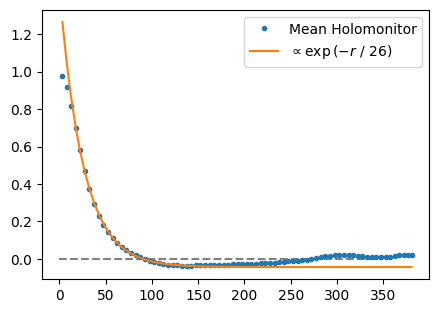

In [ ]:
i = 3
f = 30

r_arr = spatial_dist[0]
Cr_mean = np.mean(spatial_corr, axis=0)
Cr_std  = np.std(spatial_corr, axis=0)

def func(r, l, a,b):
    return a + b*np.exp(-r/l)

param, cov = curve_fit(func, r_arr[i:f], Cr_mean[i:f], p0=[30, 0, 1], sigma=Cr_std[i:f])
print(f"Correlation lenght: {param[0]:0.2f} +/- {cov[0,0]:0.2f}")

fig, ax = plt.subplots(1,1, figsize=(5,3.5))

ax.hlines(0,0,350, ls="dashed", color="gray")
ax.errorbar(r_arr, Cr_mean, yerr=Cr_std, fmt='.', label="Mean Holomonitor")
ax.plot(r_arr, func(r_arr, *param), '-', label=rf"$\propto \exp{{(-r~/~{param[0]:0.0f})}}$")
ax.legend();

In [ ]:
# IMPORT DATA
im_size = 3645
density = []
spatial_corr = []
spatial_dist = []

# tomocube
for dataset in tqdm(range(len(tomo_dict["files"]))):
    # import data
    file   = "250210.113448.MDCK dynamics.001.MDCK B.A2"
    folder = tomo_dict["files"][dataset]

    _, h_im = import_tomocube_stack(folder, file, h_scaling=vox_to_um[0], f_min=tomo_dict["fmin"][dataset], f_max=tomo_dict["fmax"][dataset])
    for i in range(len(h_im)):
        h_im[i][h_im[i] <= 0] = np.mean(h_im[i])

    df = pd.read_csv(f"{folder}/area_volume_filtered.csv")
    blur_factor = tomo_dict["blur_factor"]
    conversion_factor = vox_to_um

    # blur data
    hblur = np.zeros_like(h_im)
    for f in range(len(h_im)):
        r_cell = average_cell_radius(df, f, conversion_factor, blur_factor=blur_factor)
        hblur_tmp = gaussian_filter(h_im[f], r_cell)

        hblur[f] = hblur_tmp

    im = hblur[:,:im_size, :im_size]
    autocorr = np.zeros_like(im[0])
    for t in range(len(im)):
        autocorr += spatial_autocorrelation(im[t]) / len(im)
    
    dist, mean, std = radial_distribution(autocorr, vox_to_um)
    spatial_corr.append(mean)
    spatial_dist.append(dist)


100%|██████████| 1/1 [01:23<00:00, 83.54s/it]


Correlation lenght: 10.00 +/- nan


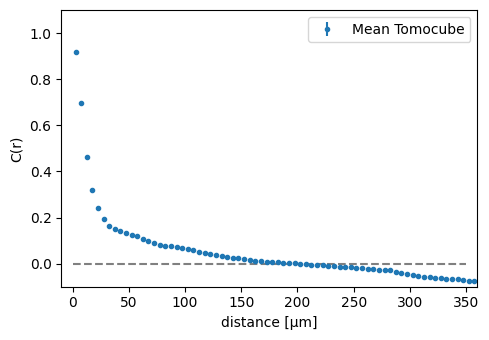

In [ ]:
i = 0
f = 16

r_arr = spatial_dist[0]
Cr_mean = np.mean(spatial_corr, axis=0)
Cr_std  = np.std(spatial_corr, axis=0)

def func(r, l, a,b):
    return a + b*np.exp(-r/l)

param, cov = curve_fit(func, r_arr[i:f], Cr_mean[i:f], p0=[10, 0.12, 1], sigma=Cr_std[i:f])
print(f"Correlation lenght: {param[0]:0.2f} +/- {cov[0,0]:0.2f}")

ax.errorbar(r_arr, Cr_mean, yerr=Cr_std, fmt='.', label="Mean Tomocube")
#ax.plot(r_arr, func(r_arr, *param), '-', label=rf"$\propto \exp{{(-r~/~{param[0]:0.0f})}}$")

ax.set(xlabel="distance [µm]", ylabel="C(r)", ylim=(-.1,1.1), xlim=(-10, 360))
ax.legend()
fig.tight_layout()
fig

In [ ]:
#fig.savefig("../../figs/autocorrelation/mean_spatial.png")

In [41]:
im_size = 975
dataset = 1
# import data
file = holo_dict["files"][dataset].split("/")[-1]
folder = holo_dict["files"][dataset].split(file)[0]

h_im = import_holomonitor_stack(folder, file, f_min=holo_dict["fmin"][dataset], f_max=holo_dict["fmax"][dataset])[:, :im_size, :im_size]
#h_im[h_im > h_max] = h_max

df = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")
blur_factor = holo_dict["blur_factor"]
conversion_factor = pix_to_um

# blur data
hblur = np.zeros_like(h_im)
for f in range(len(h_im)):
    r_cell = average_cell_radius(df, f, conversion_factor, blur_factor=blur_factor)
    hblur_tmp = gaussian_filter(h_im[f], r_cell)

    hblur[f] = hblur_tmp

In [133]:
def spatial_autocorrelation(im):
    # center input around zero (ensure negative correlation)
    var = np.mean(im**2) - np.mean(im)**2
    im  = (im - np.mean(im)) / np.sqrt(var)

    #im = np.pad(im, pad_width=int(len(im)/2), mode="constant")

    # compute FFT of image
    fft_im  = np.fft.fft2(im, norm="ortho")
    ifft_im = np.fft.ifft2(np.abs(fft_im)**2, norm="ortho")
    ifft_im = np.fft.fftshift(ifft_im)

    # normalize output
    ifft_im_norm = np.real(ifft_im) / np.max(np.real(ifft_im))

    return ifft_im_norm

/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


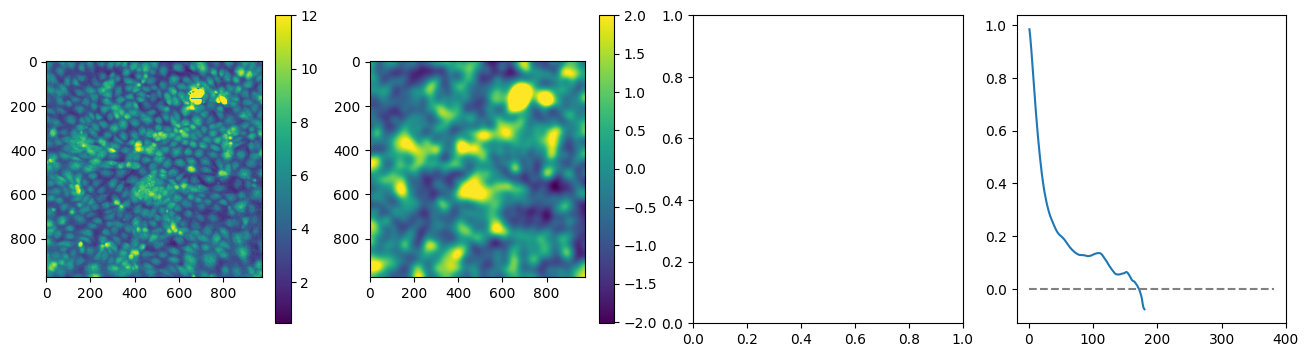

In [ ]:
t = 40
im_size = 9751
#autocorr = spatial_autocorrelation(hblur[t, :im_size, :im_size])
#dist, mean, std = radial_distribution(autocorr, pix_to_um, binsize=1)
autocorr = temporal_autocorrelation2(hblur)


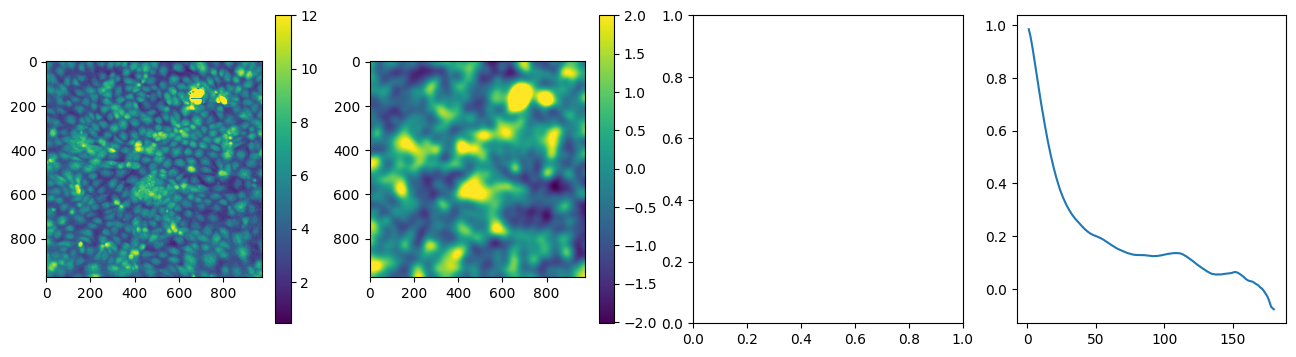

In [151]:

#plt.plot(dist, mean)
fig, ax = plt.subplots(1,4, figsize=(16,4))
im0 = ax[0].imshow(h_im[0, :im_size, :im_size], vmax=12)
im1 = ax[1].imshow(hblur[0, :im_size, :im_size] - np.mean(hblur[0, :im_size, :im_size]), vmax=2)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
#ax[2].imshow(autocorr)
ax[3].plot(autocorr)
#ax[3].hlines(0, 0, max(dist), ls="dashed", color="gray")

In [ ]:
def temporal_autocorrelation1(im, t):
    std_0 = np.sqrt(np.mean((im[0]**2)) - np.mean(im[0])**2)
    std_t = np.sqrt(np.mean((im[t]**2)) - np.mean(im[t])**2)

    return np.mean(  )# / (std_0 * std_t)

In [70]:
def temporal_autocorrelation2(im):
    for t in range(len(im)):
        var   = np.mean(im[t]**2) - np.mean(im[t])**2
        im[t] = (im[t] - np.mean(im[t])) / np.sqrt(var)
        
    auto_corr = np.zeros(len(im))
    for dt in range(len(im)):
        auto_corr[dt] = np.mean((im * np.roll(im, axis=0, shift=-dt))[:-dt])

    return auto_corr

In [45]:
im = np.copy(hblur)
autocorr = np.zeros_like(im)
for t in range(len(im)):
    im[t][im[t] <=0] = np.mean(im[t])
    std_0 = np.sqrt(np.mean((im[0]**2)) - np.mean(im[0])**2)
    std_t = np.sqrt(np.mean((im[t]**2)) - np.mean(im[t])**2)
    autocorr[t] = (im[0]-np.mean(im[0])) * (im[t]-np.mean(im[t])) / (std_0*std_t)

In [71]:
# # # temporal autocorrelation
auto_corr2 = temporal_autocorrelation2(hblur)
time = (np.arange(len(hblur))) / 12


/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
plt.imshow(im[0] - np.roll())

(180, 975, 975)

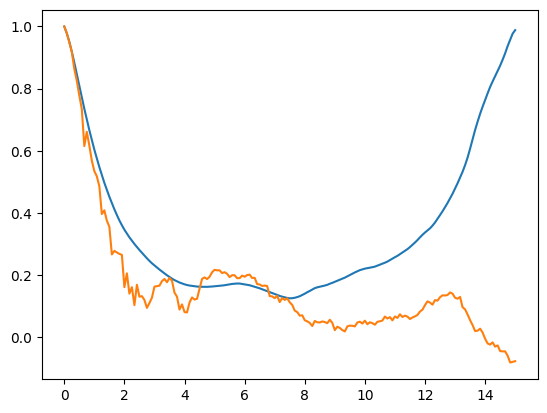

In [59]:
plt.plot(time, auto_corr2)
plt.plot(time, np.mean(autocorr, axis=(1,2)))

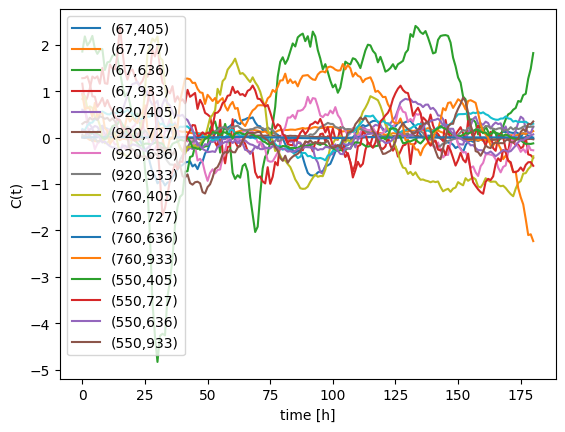

In [46]:
#time = np.linspace(0,len(auto_corr2)) * 10
fig, ax = plt.subplots(1,1)
#ax.hlines(time.min(), time.max(), 0, ls="dashed", color="gray")
#ax.plot(auto_corr1, '.', label=file)
#ax.plot(auto_corr2, '.', label=file)

i_idx = np.random.randint(len(im[0]), size=4)
j_idx = np.random.randint(len(im[0]), size=4)

for i in i_idx:
    for j in j_idx:
        plt.plot(autocorr[:,i,j], label=f"({i},{j})")
ax.set(xlabel="time [h]", ylabel="C(t)")
ax.legend()
#plt.savefig("../../figs/fluctuations/time_correlation_holomonitor.png")

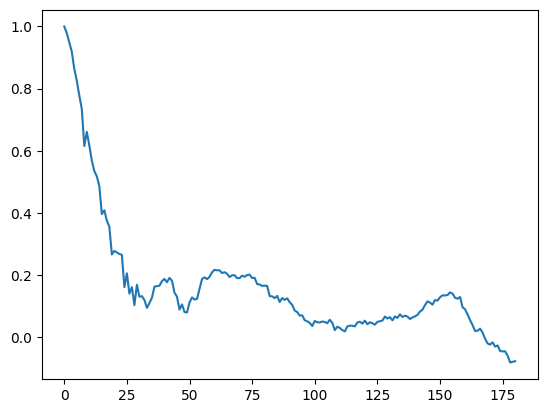

In [49]:
# plt.plot(h_im[:,869, 408])
# plt.plot(hblur[:,869, 408])
# plt.plot(autocorr[:,869, 408])
plt.plot(np.mean(autocorr, axis=(1,2)))

In [125]:
tracks = tp.link(df, search_range=10, memory=5)
tracks = tp.filter_stubs(tracks, threshold=5)

particles = []
track_len = []

for p in range(max(tracks.particle)):
    particles.append(p)
    track_len.append(sum(tracks.particle==p))

particles = np.array(particles)
track_len = np.array(track_len)

track_mask = particles[track_len >= 120]

Frame 144: 786 trajectories present.


In [140]:
track_heights = []
track_frames = []
for p in track_mask:
        tmp_df = tracks[tracks.particle == p]
        track_heights.append(tmp_df.h_avrg.values[:120])
        track_frames.append(tmp_df.frame.values[:120])

In [145]:
track_heights = np.array(track_heights)
autor_corr = np.zeros(120)
for t in range(120):
    auto_corr[t] = np.mean(track_heights[:,0]*track_heights[:,t]) - np.mean(track_heights[:,0])*np.mean(track_heights[:,t])

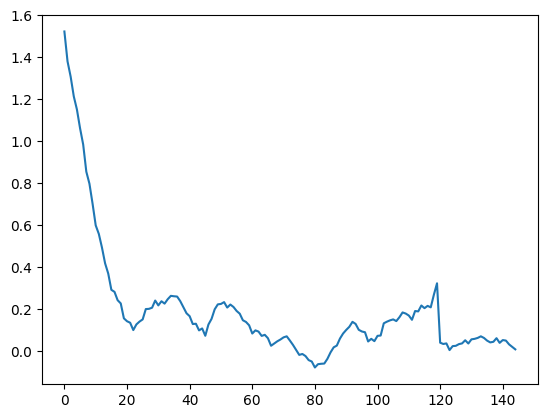

In [146]:
plt.plot(auto_corr)